## 10.2 Attention pooling : Nadaraya-watson kernel regreesion
在上节介绍框架下的注意力机制的主要成份：query、key、value的基础上形成注意力汇聚，1964年提出来的Nadaraya- Watson核回归是一个简单但完整的例子，可以用于演示具有attention的机器学习例子

In [1]:
import torch
from torch import nn

### 生成数据集
考虑一个最基本的非线性函数
$$y=2sin(x)+x_0.8+\sigma_i$$

In [2]:
n_train=50
x_train,_=torch.sort(torch.rand(n_train)*5)
def f(x):
    return 2*torch.sin(x)+x**0.8

y_train=f(x_train)+torch.normal(0.0,0.5,(n_train,)) #排序样本输出
x_test=torch.arange(0,5,0.1)
y_truth=f(x_test)
n_test=len(x_test)
n_test

50

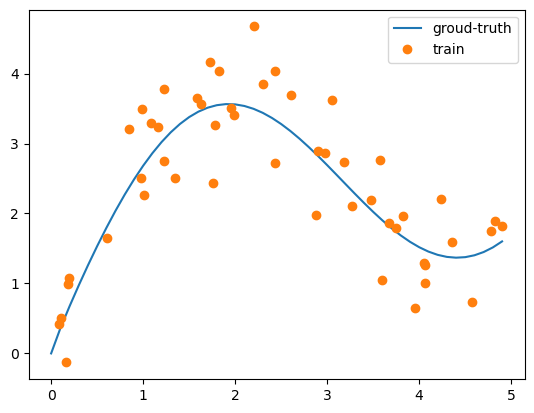

In [3]:
# 可以绘制truth和pred
import matplotlib.pyplot as plt
plt.plot(x_test,y_truth,label='groud-truth')
plt.plot(x_train,y_train,'o',label='train')
plt.legend()

### where we go next?
我们从数据中如何来拟合这样的非线性函数，从linear regression中我们给出了我们的hypothesis，这里我们同样可以参考类似的结论，但是在1964年的时候，思考的过程可能是这样的：
* 方法一：平均汇聚：利用均值来代替预测值
* 方法二：非参数注意力汇聚：利用x的距离作为权重来对y进行加权来得到输出
$$f(x)=\Sigma \frac{K(x-x_i)}{\Sigma K(X-X_j)}$$
这里的kernel方法在之前SVM中也使用过，是一种将低纬度的向量像高纬度扩张的方式，在此我们并不介绍kernel方法的详细过程，而是在这个方法的启发下得到一个注意力汇聚的公式
* 方法三：注意力汇聚，是在方法二的基础上的改进，更加通用
$$f(x)=\Sigma \alpha(x,x_i)y_i$$
只不过我们需要所有的$\alpha$都非负，且总和等于1

PS:我们在方法三将kernel function化简成为一种\alpha，不仅仅是一层抽象，同样也是在这个基础上可以将非参数化的kernel方法升级为一种参数化的方法

<function matplotlib.pyplot.legend(*args, **kwargs)>

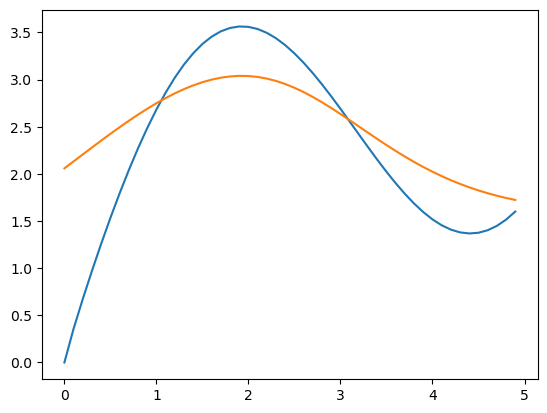

In [4]:
# X-repeat的形状为n_test,n_train
# 每一行都表示相同的测试输入
X_repeat=x_test.repeat_interleave(n_train).reshape(-1,n_train)
# attention weight的形状 n_test，n_train
# 每一行都要包含在给定的每个查询的值之间分配注意力权重
attention_weights=nn.functional.softmax(-(X_repeat-x_train)**2/2,dim=1)
y_hat=torch.matmul(attention_weights,y_train)
plt.plot(x_test,y_truth,label='true')
plt.plot(x_test,y_hat,label='False')
plt.legend

<AxesSubplot: >

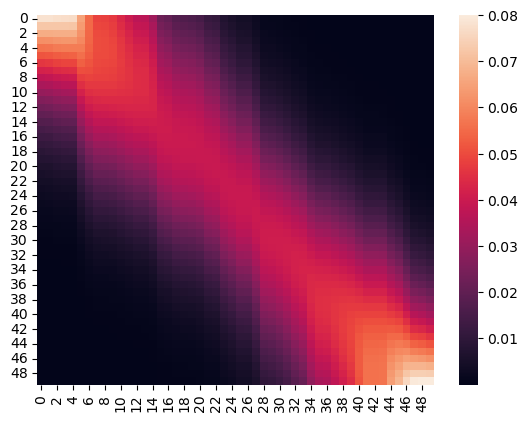

In [6]:
import seaborn as sns
sns.heatmap(attention_weights.numpy())

###  带参数的注意力汇聚
我们可以使用可学习的参数w，利用模型训练来得到w，在其中设计的过程需要批量矩阵乘法

In [7]:
X=torch.ones(2,1,4)
Y=torch.ones(2,4,6)
torch.bmm(X,Y).shape

torch.Size([2, 1, 6])

In [8]:
# 在注意力机制的背景，我们可以小批量矩阵乘法来计算小批量数据中的加权平均值
weigths=torch.ones((2,10))*0.1
values=torch.arange(20.0).reshape(2,10)
torch.bmm(weigths.unsqueeze(1),values.unsqueeze(-1))

tensor([[[ 4.5000]],

        [[14.5000]]])

In [14]:
class NWKernelRegression(nn.Module):
    def __init__(self,**kwargs):
        super().__init__(**kwargs)
        self.w=nn.Parameter(torch.rand((1,),requires_grad=True))
    
    def forward(self,queries,keys,values):
        queries=queries.repeat_interleave(keys.shape[1]).reshape((-1,keys.shape[1]))
        self.attention_weights=nn.functional.softmax(-((queries-keys)*self.w)**2/2,dim=1)
        # value 为形状(queries，key-value)
        return torch.bmm(self.attention_weights.unsqueeze(1),values.unsqueeze(-1)).reshape(-1)


In [15]:
# train
X_tile=x_train.repeat((n_train,1))
Y_tile=y_train.repeat((n_train,1))
keys=X_tile[(1-torch.eye(n_train)).type(torch.bool)].reshape((n_train,-1))
values=Y_tile[(1-torch.eye(n_train)).type(torch.bool)].reshape((n_train,-1))

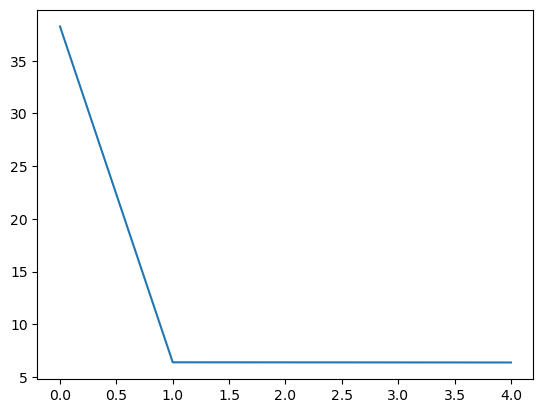

In [25]:
net=NWKernelRegression()
loss=nn.MSELoss(reduction='none')
trainer=torch.optim.SGD(net.parameters(),lr=0.5)

loss_mat=[]
for epoch in range(5):
    trainer.zero_grad()
    l=loss(net(x_train,keys,values),y_train)
    l.sum().backward()
    trainer.step()
    loss_mat.append(l.sum().detach().numpy())

plt.plot(list(range(epoch+1)),loss_mat)


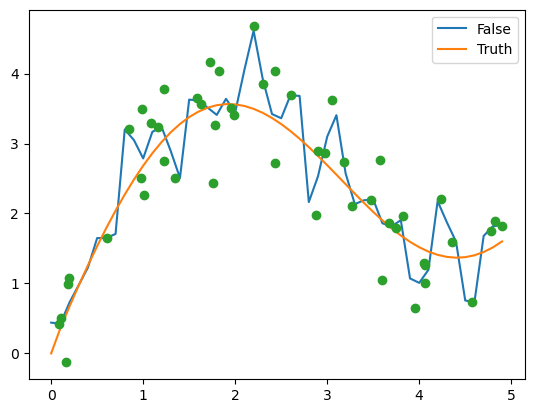

In [27]:
# 查看效果
from torch import unsqueeze


keys=x_train.repeat((n_test,1))
values=y_train.repeat(n_test,1)
y_hat=net(x_test,keys,values).unsqueeze(1).detach()
plt.plot(x_test,y_hat,label='False')
plt.plot(x_test,y_truth,label='Truth')
plt.plot(x_train,y_train,'o')
plt.legend()

<AxesSubplot: >

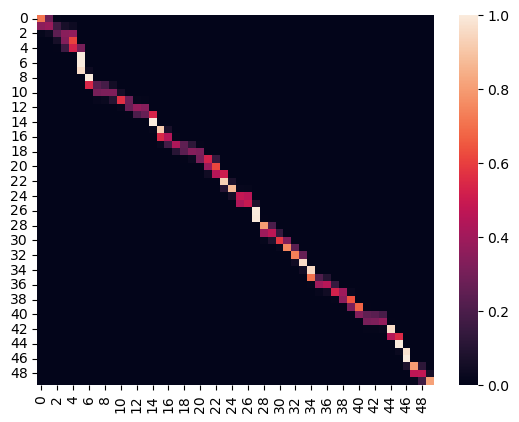

In [41]:
sns.heatmap(net.attention_weights.detach().numpy())